# Carga de datos

In [1]:
import torch
print(torch.__version__)  # Debe ser >= 2.6.0

2.6.0+cu124


In [2]:
import pandas as pd
from datasets import Dataset
from pathlib import Path
import re
import unicodedata

# Cargar tu .csv
df = pd.read_csv("transcript.csv")

c:\Users\galfa\Documents\Proyecto IA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def clean_transcription_text(transcriptionText):
    # Convertir a minúsculas
    transcriptionText = transcriptionText.lower()

    # Normalizar tildes y ñ -> n
    transcriptionText = unicodedata.normalize("NFD", transcriptionText)
    transcriptionText = transcriptionText.encode("ascii", "ignore").decode("utf-8")

    # Eliminar todo lo que no sea letras o espacios
    transcriptionText = re.sub(r"[^a-zñ\s]", "", transcriptionText)

    # Eliminar espacios múltiples
    transcriptionText = re.sub(r"\s+", " ", transcriptionText).strip()

    return transcriptionText

df["transcripcion"] = df["transcripcion"].apply(lambda x: clean_transcription_text(x).replace(" ", "|"))
df.to_csv("transcripciones_limpias.csv", index=False)

## Alternativa: Modelo Jonatasgrosman

In [3]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# Carga el modelo bilingüe (ya viene con tokenizer y feature extractor integrados)
processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-spanish")
model = Wav2Vec2ForCTC.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-spanish")

# Asegura el pad_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

In [4]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-ZáéíóúñüÁÉÍÓÚÑÜ\s']", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["transcripcion"] = df["transcripcion"].apply(clean_text)
df.to_csv("transcripciones_limpias.csv", index=False)

In [5]:
# Convertir a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

In [6]:
import torchaudio

def load_audio(batch):
    speech_array, sampling_rate = torchaudio.load(batch["archivo"])
    batch["speech"] = speech_array[0].numpy()
    batch["sampling_rate"] = sampling_rate
    return batch

dataset = dataset.map(load_audio)

Map: 100%|██████████| 118/118 [00:01<00:00, 111.91 examples/s]


In [ ]:
import json
from collections import Counter

def extract_all_chars(dataset):
    all_text = " ".join(dataset["transcripcion"])  # o el campo correcto con tus transcripciones
    return list(set(all_text))

# Extrae vocabulario
vocab_chars = extract_all_chars(dataset)
vocab_dict = {char: i for i, char in enumerate(sorted(vocab_chars))}
vocab_dict["|"] = len(vocab_dict)
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

In [6]:
with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab_dict, f, ensure_ascii=False)

In [7]:
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor

tokenizer = Wav2Vec2CTCTokenizer("vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)


In [8]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53",
                                       ctc_loss_reduction="mean",
                                       pad_token_id=processor.tokenizer.pad_token_id)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
print(processor.tokenizer.get_vocab())

{'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '|': 4, "'": 5, '-': 6, 'a': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'h': 14, 'i': 15, 'j': 16, 'k': 17, 'l': 18, 'm': 19, 'n': 20, 'o': 21, 'p': 22, 'q': 23, 'r': 24, 's': 25, 't': 26, 'u': 27, 'v': 28, 'w': 29, 'x': 30, 'y': 31, 'z': 32, 'á': 33, 'é': 34, 'í': 35, 'ñ': 36, 'ó': 37, 'ö': 38, 'ú': 39, 'ü': 40}


# Visualización de los datos

In [8]:
for i in range(5):
    print(f"[{i}] {dataset[i]['archivo']} --> {dataset[i]['transcripcion']}")

[0] Audios_WAV\Bryan\brayan_partes_000.wav --> how to use this book in this book will show you the power of house plants to transform your life each shipper explores different aspects of their
[1] Audios_WAV\Bryan\brayan_partes_001.wav --> to try the ship is covered plant power for the meaning learn how plants can subtly transform your relationships with yourself boost your mood reduce stress and help you live a happy life
[2] Audios_WAV\Bryan\brayan_partes_002.wav --> power for heal read about home plans you can make your home healthy and in turn make your healthy too kitchen garden anyway plants power for creativity understand how
[3] Audios_WAV\Bryan\brayan_partes_003.wav --> plants can fill up your senses and engage your imaginations plants power for productivity learn why adding a plant to your desk could make you happier and
[4] Audios_WAV\Bryan\brayan_partes_004.wav --> more productivity at work plan for you social life and nothing makes our social space more welcoming than plan

Transcripción: how to use this book in this book will show you the power of house plants to transform your life each shipper explores different aspects of their
Tamaño del audio: torch.Size([1, 319888])
Duración (s): 19.993


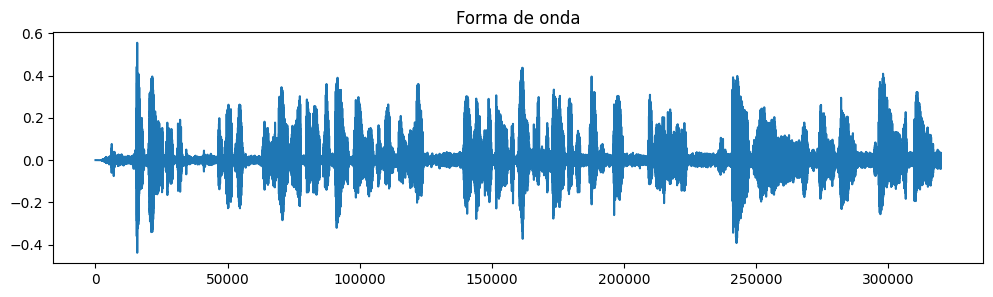

c:\Users\galfa\Documents\Proyecto IA\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


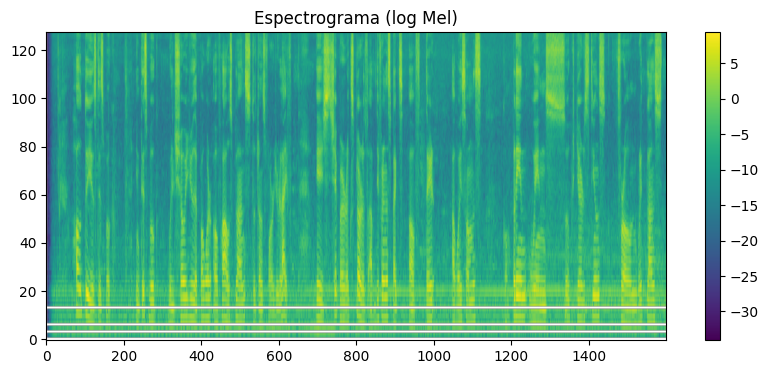

In [9]:
import matplotlib.pyplot as plt

def show_audio_spectogram(index):
    sample = dataset[index]
    audio, sr = torchaudio.load(sample["archivo"])

    print("Transcripción:", sample["transcripcion"])
    print("Tamaño del audio:", audio.shape)
    print("Duración (s):", audio.shape[1]/sr)

    # Forma de onda
    plt.figure(figsize=(12, 3))
    plt.plot(audio[0].numpy())
    plt.title("Forma de onda")
    plt.show()

    # Espectrograma
    plt.figure(figsize=(10, 4))
    spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(audio)
    plt.imshow(spec.log2()[0,:,:].numpy(), origin='lower', aspect='auto')
    plt.title("Espectrograma (log Mel)")
    plt.colorbar()
    plt.show()

show_audio_spectogram(0)

# Preparación de los datos

In [8]:
import torch

def prepare_dataset(batch):
    # Audio: feature extraction
    audio_inputs = processor.feature_extractor(
        batch["speech"],
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    # Texto: tokenización
    text_inputs = processor.tokenizer(
        batch["transcripcion"],
        return_tensors="pt",
        padding=True
    )

    return {
        "input_values": audio_inputs.input_values.numpy().tolist(),
        "attention_mask": audio_inputs.attention_mask.numpy().tolist(),
        "labels": text_inputs.input_ids.numpy().tolist()
    }

In [9]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names, batched=True, batch_size=8)

Map: 100%|██████████| 118/118 [00:21<00:00,  5.57 examples/s]


# Entrenamiento del modelo

In [10]:
split_dataset = dataset.train_test_split(test_size=0.1)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

In [ ]:
def add_input_ids(example):
    example["input_ids"] = example["input_values"]
    if "attention_mask" in example:
        example["attention_mask"] = example["attention_mask"]
    return example

train_dataset = train_dataset.map(add_input_ids)
eval_dataset = eval_dataset.map(add_input_ids)

In [11]:
from dataclasses import dataclass
from typing import Dict, List, Union
import torch

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Separar inputs (audio) y labels (IDs de texto)
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        # Padding de inputs (usa feature_extractor)
        batch = self.processor.feature_extractor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt"
        )

        # Padding de labels (manualmente)
        labels_batch = self.processor.tokenizer.pad(
            label_features,
            padding=self.padding,
            return_tensors="pt"
        )

        # Reemplazar padding_token_id por -100 (ignorado por CTC loss)
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch["input_ids"] == self.processor.tokenizer.pad_token_id, -100
        )

        batch["labels"] = labels
        return batch

In [12]:
data_collator = DataCollatorCTCWithPadding(processor=processor)

In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./modelo_final",
    group_by_length=True,
    per_device_train_batch_size=4,
    num_train_epochs=10,
    gradient_checkpointing=True,
    fp16=False,
    save_total_limit=2,
    logging_steps=10,
    save_steps=500,
    learning_rate=1e-4,
    warmup_steps=100,
    logging_dir="./logs",
)

# Crea el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,     # Usar el train_dataset, no todo el dataset
    eval_dataset=eval_dataset,       # Agregamos también eval dataset
    tokenizer=processor,   
    data_collator=data_collator,  # Aquí está la clave: tu collate_fn personalizado
)

C:\Users\galfa\AppData\Local\Temp\ipykernel_22668\991177478.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
trainer.train()

Step,Training Loss
10,0.787800
20,0.844600
30,0.664000
40,0.656400
50,0.508700
60,0.567700
70,0.506800
80,0.441100
90,0.458500
100,0.330300


TrainOutput(global_step=270, training_loss=0.35840794951827437, metrics={'train_runtime': 2446.4206, 'train_samples_per_second': 0.433, 'train_steps_per_second': 0.11, 'total_flos': 6.422269288270559e+17, 'train_loss': 0.35840794951827437, 'epoch': 10.0})

In [15]:
trainer.save_model("modelo_final")
processor.save_pretrained("modelo_final")
model.save_pretrained("modelo_final")

# Evaluación del modelo

In [16]:
from jiwer import wer

def transcribe_audio(audio):
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)

    # Mover inputs a GPU si el modelo está en GPU
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits
    decoded = processor.batch_decode(logits.argmax(dim=-1))
    print(decoded)
    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])


# Comparar con ground truth
pred = transcribe_audio(dataset[0]["input_values"])
real = processor.decode(dataset[0]["labels"])

print("Predicción:", pred)
print("Real:", real)
print("WER:", wer(real, pred))

c:\Users\galfa\Documents\Proyecto IA\.venv\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


['how to use this book in this book will show you the power of hous plants to transform your life each super explores different aspects of the']
Predicción: how to use this book in this book will show you the power of hous plants to transform your life each super explores different aspects of the
Real: how to use this bok in this bok wil show you the power of house plants to transform your life each shiper explores diferent aspects of their
WER: 0.25925925925925924


In [17]:
from torchsummary import summary
import torch
from tqdm import tqdm

# Verifica si estás usando GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluar múltiples ejemplos
predicciones = []
ground_truths = []
errores = []

for i in tqdm(range(len(dataset))):
    entrada = dataset[i]["input_values"]
    etiqueta = processor.decode(dataset[i]["labels"])

    # Inference
    inputs = processor(entrada, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcripcion = processor.decode(predicted_ids[0])

    predicciones.append(transcripcion)
    ground_truths.append(etiqueta)

    # Guardar errores por muestra
    errores.append({
        "real": etiqueta,
        "predicho": transcripcion,
        "wer_individual": wer(etiqueta, transcripcion)
    })

# Calcular el WER general
wer_total = wer(ground_truths, predicciones)

# Mostrar resultados
print(f"\n✅ WER total en el dataset: {wer_total:.4f}")

# Mostrar ejemplos
df_errores = pd.DataFrame(errores)
print("\n🔍 Ejemplos de transcripciones:")
print(df_errores.sample(5))

# Guardar CSV opcional
df_errores.to_csv("evaluacion_transcripciones.csv", index=False)


100%|██████████| 118/118 [00:57<00:00,  2.05it/s]


✅ WER total en el dataset: 0.1984

🔍 Ejemplos de transcripciones:
                                                 real  \
36  for grenery and humans alike your plants can b...   
89  en cordel no neóino ni las grandes naciones de...   
2   power for heal read about home plans you can m...   
14  a ritual stand helps you take god care of your...   
23  lidwes when you fel a hover wealth be life a s...   

                                             predicho  wer_individual  
36  for renery and humans alike your plants can be...        0.166667  
89  en cordel none rino ni las grandes naciones de...        0.068966  
2   power for heal read about home plans you can m...        0.137931  
14  an ritual stand help you take good care of you...        0.275862  
23  lidwees whhen you feel hover wealth blive a sm...        0.560000  


In [18]:
print("Predicted IDs:", predicted_ids[0].tolist())
print("Decoded:", processor.decode(predicted_ids[0], skip_special_tokens=True))

Predicted IDs: [0, 0, 0, 0, 0, 7, 0, 0, 19, 0, 0, 7, 0, 0, 20, 0, 11, 0, 0, 0, 9, 0, 0, 0, 11, 0, 0, 24, 0, 4, 4, 0, 0, 0, 0, 19, 0, 0, 7, 0, 16, 16, 0, 11, 0, 0, 25, 0, 0, 26, 0, 0, 27, 27, 0, 0, 0, 21, 0, 0, 0, 0, 25, 0, 0, 21, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 27, 27, 11, 11, 4, 4, 0, 0, 25, 0, 0, 0, 34, 0, 0, 4, 4, 23, 27, 27, 11, 4, 4, 11, 0, 20, 4, 4, 20, 0, 0, 15, 0, 20, 20, 0, 13, 0, 0, 0, 39, 0, 20, 4, 4, 0, 21, 21, 0, 0, 0, 0, 26, 0, 0, 24, 0, 0, 0, 21, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 11, 0, 0, 24, 0, 0, 33, 0, 4, 4, 16, 0, 7, 7, 0, 0, 0, 0, 19, 0, 0, 33, 0, 0, 0, 25, 0, 4, 4, 0, 0, 0, 15, 15, 0, 0, 0, 13, 27, 27, 0, 0, 7, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,